In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from scipy.stats import chi2_contingency 
from skorch import NeuralNetRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df = pd.read_csv('df_bkg_sample.csv')

In [6]:
df = df.sample(frac=1., random_state=42)
df

ungr_lead  ungr_sub        mjj  eta_lead   eta_sub     pt_asym  \
166589          20        23  5576.9194  0.368432  0.348929  309.501950   
1075449         24        35  1978.8964 -1.269925 -0.537691  101.955444   
1284563         44        67  2036.2617 -0.343261 -0.219767   14.143127   
324893          35        37  2669.7470  0.849239 -1.731860    4.794556   
46484           51        39  2128.3455  0.800568  0.815687   48.037964   
...            ...       ...        ...       ...       ...         ...   
110268          29        30  4212.6426 -1.253183  1.978422  247.874700   
1692743         27        33  1969.8221 -0.485294 -0.205480  191.383670   
2356330         22        33  5261.3525 -0.523453  0.242016  543.455100   
2229084         66        27  2224.1710  0.634813 -0.833996  204.575200   
2219110         26        42  1617.9154  1.002954  0.956942  289.465400   

             dyjj  labels  
166589   0.019837       0  
1075449  0.742328       0  
1284563  0.146889       0  
324893   2.551962       0  
46484    0.013934       0  
...           ...     ...  
110268   3.211114       0  
1692743  0.277194       0  
2356330  0.762695       0  
2229084  1.407361       0  
2219110  0.049826       0  

[2480842 rows x 8 columns]

In [7]:
features = df.iloc[:, :-1]
labels = df.labels

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [9]:
val_set = pd.DataFrame(x_test).sample(frac=0.33, random_state=42)

In [10]:
x_test = pd.DataFrame(x_test).drop(index=val_set.index).values

In [11]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
val_set = scaler.fit_transform(val_set)

In [23]:
loss_fn = nn.MSELoss()

In [12]:
class VAE(nn.Module):
    def __init__(self, input_dim = 7, h_dim = 16, z_dim = 10):
        super().__init__()
        #encoder
        self.dat_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        #decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2dat = nn.Linear(h_dim, input_dim)
    
        self.relu = nn.ReLU()
        
    def encode(self, x):
        h = self.relu(self.dat_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma
    
    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2dat(h))
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparam = mu+sigma*epsilon
        x_recon = self.decode(z_reparam)
        return x_recon, mu, sigma

In [13]:
input_dim = 7
h_dim = 16#32
z_dim = 10#2
epochs = 5#10
batch_size = 32
lr = 1e-5

In [14]:
x_train.shape

(1984673, 7)

In [15]:
train_loader = DataLoader(dataset = x_train.astype(np.float32), batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(dataset=val_set.astype(np.float32), batch_size=batch_size, shuffle = True)

In [16]:
model = VAE(input_dim, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Optimization with gridsearchcv

In [17]:
net = NeuralNetRegressor(VAE)

In [18]:
net.set_params(train_split=False, verbose=0)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.VAE'>,
)

In [121]:
params = {
    'max_epochs': [5, 10, 20],
    'module__z_dim': [10, 20],
    'module__h_dim': [16, 32, 64]
}
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='neg_mean_squared_error', verbose=2)

gs.fit(x_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=20; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=20; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=20; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=20; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=16, module__z_dim=20; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=32, module__z_dim=10; total time=   0.0s
[CV] END ...max_epochs=5, module__h_dim=32, modu

C:\Users\ojjy1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ojjy1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 678, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Users\ojjy1\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan n

### best params: {'max_epochs': 5, 'module__h_dim': 16, 'module__z_dim': 10}

## Optimization with bayes

In [19]:
def training_func(lr):
    model = VAE(input_dim, h_dim, z_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = 0
    for epoch in range(epochs):
        loop = tqdm(enumerate(train_loader))
        print(loop)
        for i, x in loop:
            #Forward pass
            x = x.to(device).view(x.shape[0], input_dim)
            x_recon, mu, sigma = model(x)
        
            #compute loss
            recon_loss = loss_fn(x_recon, x)
            kl_div = -torch.sum(1+torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        
            #backprop
            loss= recon_loss+kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss = loss.item())
    
    out = 0.
    if loss.item() == np.nan:
        out = 0.5
    else:
        out = 1-loss.item()
    return out 

In [20]:
p_bounds = {'lr':(1e-7, 1)}

In [21]:
optimizer = BayesianOptimization(f = training_func,
                                 pbounds = p_bounds, verbose = 2,
                                 random_state = 42)

In [24]:
optimizer.maximize(n_iter=10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |    lr     |
-------------------------------------


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 1         | 0.9039    | 0.9507    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 2         | 0.8246    | 0.732     |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 3         | 0.8696    | 0.5987    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 4         | 0.99      | 0.156     |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 5         | 0.9576    | 0.156     |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 6         | 0.994     | 0.05808   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 7         | 0.7957    | 0.8662    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 8         | 0.8563    | 0.6011    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 9         | 0.8841    | 0.7081    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 10        | 0.9752    | 0.05816   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 11        | 0.9876    | 0.058     |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 12        | 0.9618    | 0.1561    |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 13        | 0.9816    | 0.05832   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 14        | 0.9819    | 0.05782   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 15        | 0.9532    | 0.05844   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 16        | 0.9927    | 0.05769   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 17        | 0.9645    | 0.05758   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 18        | 0.9899    | 0.05729   |


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
| 19        | 0.9889    | 0.05715   |
Best result: {'lr': 0.05808370635983825}; f(x) = 0.9940320099703968.


## Best results: {'lr': 0.05808370635983825}; f(x) = 0.9940320099703968.)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=optimizer.max["params"]['lr'])

In [68]:
loss_vals = []
val_loss_vals = []
for epoch in range(epochs):
    loop = tqdm(enumerate(train_loader))
    print(loop)
    for i, x in loop:
        #Forward pass
        x = x.to(device).view(x.shape[0], input_dim)
        x_recon, mu, sigma = model(x)
        
        #compute loss
        recon_loss = loss_fn(x_recon, x)
        kl_div = -torch.sum(1+torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        
        #backprop
        loss= recon_loss+kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss = loss.item())
    loss_vals.append(loss.item())
    
    val_loop = tqdm(enumerate(valid_loader))
    for j, v in val_loop:
        v = v.to(device).view(v.shape[0], input_dim)
        val_recon, val_mu, val_sigma = model(v)
        val_recon = loss_fn(val_recon, v)
        val_kl = -torch.sum(1+torch.log(val_sigma.pow(2)) - val_mu.pow(2) - val_sigma.pow(2))
        val_loss = val_recon+val_kl
    val_loss_vals.append(val_loss.item())
    
    print('Training loss: {}\nValidation loss: {}'.format(loss.item(), val_loss.item()))

0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Training loss: 0.011333680711686611
Validation loss: 0.02784580923616886


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Training loss: 0.05510992184281349
Validation loss: 0.02577950805425644


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Training loss: 0.06030672788619995
Validation loss: 0.07625355571508408


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Training loss: 0.017705390229821205
Validation loss: 0.021793529391288757


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Training loss: 0.010218623094260693
Validation loss: 0.02284608781337738


In [69]:
loss_vals.reverse()
loss_vals = loss_vals[:5]
loss_vals.reverse()

In [70]:
val_loss_vals.reverse()
val_loss_vals = val_loss_vals[:5]
val_loss_vals.reverse()

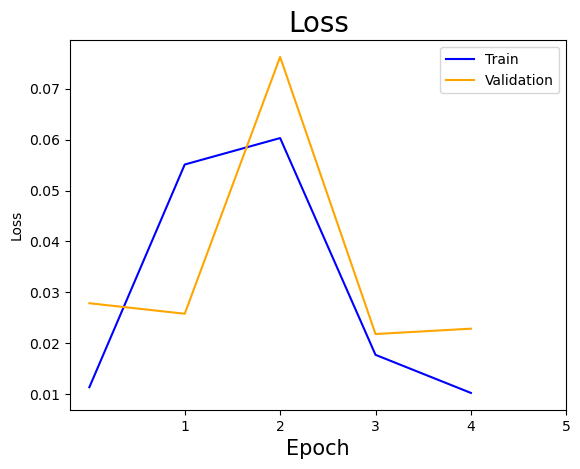

In [71]:
plt.title('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss')
plt.plot(loss_vals, color='blue', label = 'Train')
plt.plot(val_loss_vals, color = 'orange', label = 'Validation')
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [72]:
info = [loss_vals, val_loss_vals]
chi2, p, dof, _ = chi2_contingency(info)

In [73]:
print('Chi2: {}\np-value: {}\ndof: {}'.format(chi2, p, dof))

Chi2: 0.023591441935504942
p-value: 0.9999309751527969
dof: 4


### Any p-value we set is going to have the null hypothesis accepted, so we can pretty safely say we aren't overfitting here

In [42]:
torch.save(model.state_dict(), 'vae_optimized.pth')

In [10]:
#Later to restore:
model = VAE()
model.load_state_dict(torch.load('vae_optimized.pth'))
model.eval()

VAE(
  (dat_2hid): Linear(in_features=7, out_features=32, bias=True)
  (hid_2mu): Linear(in_features=32, out_features=2, bias=True)
  (hid_2sigma): Linear(in_features=32, out_features=2, bias=True)
  (z_2hid): Linear(in_features=2, out_features=32, bias=True)
  (hid_2dat): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
)

In [43]:
test_loader = DataLoader(x_test.astype(np.float32), batch_size=batch_size)

In [44]:
y_pred = []
for inputs in test_loader:
    output = model(inputs)[0]
    y_pred.extend(output)

In [45]:
len(y_pred)

332433

In [46]:
len(x_test)

332433

In [47]:
x_test

array([[0.49295775, 0.36805556, 0.16324858, ..., 0.75635319, 0.03150417,
        0.39661069],
       [0.20422535, 0.38888889, 0.11764723, ..., 0.58190395, 0.04752486,
        0.08803627],
       [0.16197183, 0.25      , 0.23386834, ..., 0.41595439, 0.04306783,
        0.20303357],
       ...,
       [0.42253521, 0.25      , 0.16333338, ..., 0.51894174, 0.01647739,
        0.43141199],
       [0.57746479, 0.42361111, 0.53550882, ..., 0.54722252, 0.03239748,
        0.21648599],
       [0.14788732, 0.28472222, 0.1281907 , ..., 0.21438334, 0.17048407,
        0.512711  ]])

In [48]:
y_pred[0][0].item()

0.27356594800949097

In [49]:
y_pred = [[i[j].item() for j in range(len(i))] for i in y_pred]

In [50]:
y_pred[0]

[0.27356594800949097,
 0.24111193418502808,
 0.18643151223659515,
 0.5006083846092224,
 0.5430699586868286,
 0.05031558871269226,
 0.24633406102657318]

In [51]:
x_test[0]

array([0.49295775, 0.36805556, 0.16324858, 0.36522273, 0.75635319,
       0.03150417, 0.39661069])

In [52]:
cols = features.columns

In [53]:
cols

Index(['ungr_lead', 'ungr_sub', 'mjj', 'eta_lead', 'eta_sub', 'pt_asym',
       'dyjj'],
      dtype='object')

In [54]:
pred_dict = {}
for i in range(len(cols)):
    pred_dict[cols[i]] = [np.square(y_pred[j][i]-x_test[j][i]) for j in range(len(y_pred))]

In [55]:
len(pred_dict['mjj'])

332433

In [56]:
pred_dict.keys()

dict_keys(['ungr_lead', 'ungr_sub', 'mjj', 'eta_lead', 'eta_sub', 'pt_asym', 'dyjj'])

In [61]:
final_res = {}
for key, val in pred_dict.items():
    final_res[key] = (np.sqrt(np.sum(val)))/len(val)

In [62]:
list(final_res.values())

[0.00016272659985032376,
 0.0001803818493063399,
 0.0002354038566490321,
 0.00035888945277176055,
 0.0003703189286536684,
 0.00012936576356215794,
 0.0003048282875816646]

In [63]:
tot_res = (np.sqrt(np.sum(np.square(np.array(list(final_res.values()))))))/len(list(final_res.values()))

In [64]:
tot_res

0.00010000265991414114